In [4]:
!nvidia-smi

Tue May 23 16:07:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      On   | 00000000:D9:00.0 Off |                  N/A |
| 28%   23C    P8    24W / 250W |      0MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import sys
sys.executable

'/data/lise.leboudec/conda/envs/coral/bin/python'

In [6]:
import torch
import torch.nn as nn
import einops
from pathlib import Path
import os
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from omegaconf import DictConfig, OmegaConf
import omegaconf
import hydra

from coral.utils.data.load_data import get_dynamics_data, set_seed
from expe.load_models.load_models_inr import load_coral, load_dino
from expe.forwards.forwards_inr import forward_coral, forward_dino
from expe.config.run_names import RUN_NAMES
from coral.utils.data.dynamics_dataset import TemporalDatasetWithCode
from expe.visualization.visualization_functions import plot_baselines, gif_baselines, plot_errors, plot_grid, save_imshow, save_scatter


In [41]:
cuda = torch.cuda.is_available()
if cuda:
    gpu_id = torch.cuda.current_device()
    device = torch.device(f"cuda:{gpu_id}")
else:
    device = torch.device("cpu")
print("device : ", device)

data_dir = "/data/serrano/"
dataset_name = "navier-stokes-dino"
root_dir = Path(os.getenv("WANDB_DIR")) / dataset_name
sub_from = 4
sub_tr = 0.2
sub_te = 0.2

inr_run_name = RUN_NAMES[sub_from][sub_tr]["coral"]["inr"]
dyn_run_name = RUN_NAMES[sub_from][sub_tr]["coral"]["dyn"]

print("inr_run_name : ", inr_run_name)
print("dyn_run_name : ", dyn_run_name)

baselines = []
if dyn_run_name is not None:
    cfg_coral_dyn = torch.load(
        root_dir / "model" / f"{dyn_run_name}.pt")['cfg']
    baselines += ['CORAL']
if inr_run_name is not None:
        cfg_coral_inr = torch.load(
            root_dir / "inr" / f"{inr_run_name}.pt")['cfg']

# data
ntrain = cfg_coral_dyn.data.ntrain
ntest = cfg_coral_dyn.data.ntest
data_to_encode = cfg_coral_dyn.data.data_to_encode

seed = cfg_coral_dyn.data.seed
same_grid = cfg_coral_dyn.data.same_grid
setting = cfg_coral_dyn.data.setting
sequence_length_optim = None
sequence_length_in = cfg_coral_dyn.data.sequence_length_in
sequence_length_out = cfg_coral_dyn.data.sequence_length_out

print(
    f"running from setting {setting} with sampling {sub_from} / {sub_tr} - {sub_te}")

# dino
n_steps = 300
lr_adapt = 0.005

# coral
code_dim_coral = cfg_coral_inr.inr.latent_dim
width_dyn_coral = cfg_coral_dyn.dynamics.width
depth_dyn_coral = cfg_coral_dyn.dynamics.depth
inner_steps = cfg_coral_inr.optim.inner_steps

# optim
batch_size = 16
batch_size_val = 16
criterion = nn.MSELoss()

if dataset_name == 'shallow-water-dino':
    multichannel = True
else:
    multichannel = False

set_seed(seed)

(u_train, u_test, grid_tr, grid_te, _, _, _, _, u_train_ext, u_test_ext, grid_tr_ext, grid_te_ext) = get_dynamics_data(
    data_dir,
    dataset_name,
    ntrain,
    ntest,
    sequence_length=sequence_length_optim,
    sub_from=sub_from,
    sub_tr=sub_tr,
    sub_te=sub_te,
    same_grid=same_grid,
    setting=setting,
    sequence_length_in=sequence_length_in,
    sequence_length_out=sequence_length_out
)
(u_, grid_tr_up1, _, grid_te_up1, _, _, _, _, _, _, _, _) = get_dynamics_data(
    data_dir,
    dataset_name,
    ntrain,
    ntest,
    sequence_length=sequence_length_optim,
    sub_from=sub_from,
    sub_tr=1,
    sub_te=1,
    same_grid=same_grid,
    setting=setting,
    sequence_length_in=sequence_length_in,
    sequence_length_out=sequence_length_out
)


# flatten spatial dims
u_train = einops.rearrange(u_train, 'B ... C T -> B (...) C T')
grid_tr = einops.rearrange(grid_tr, 'B ... C T -> B (...) C T')
u_test = einops.rearrange(u_test, 'B ... C T -> B (...) C T')
grid_te = einops.rearrange(grid_te, 'B ... C T -> B (...) C T')
if u_train_ext is not None:
    u_train_ext = einops.rearrange(u_train_ext, 'B ... C T -> B (...) C T')
    grid_tr_ext = einops.rearrange(
        grid_tr_ext, 'B ... C T -> B (...) C T')
    u_test_ext = einops.rearrange(u_test_ext, 'B ... C T -> B (...) C T')
    grid_te_ext = einops.rearrange(
        grid_te_ext, 'B ... C T -> B (...) C T')

print(
    f"data: {dataset_name}, u_train: {u_train.shape}, u_test: {u_test.shape}")
print(f"grid: grid_tr: {grid_tr.shape}, grid_te: {grid_te.shape}")
if u_train_ext is not None:
    print(
        f"data: {dataset_name}, u_train_ext: {u_train_ext.shape}, u_test_ext: {u_test_ext.shape}")
    print(
        f"grid: grid_tr_ext: {grid_tr_ext.shape}, grid_te_ext: {grid_te_ext.shape}")

n_seq_train = u_train.shape[0]  # 512 en dur
n_seq_test = u_test.shape[0]  # 512 en dur
spatial_size = u_train.shape[1]  # 64 en dur
state_dim = u_train.shape[2]  # N, XY, C, T
coord_dim = grid_tr.shape[2]  # N, XY, C, T
T = u_train.shape[-1]

ntrain = u_train.shape[0]  # int(u_train.shape[0]*T)
ntest = u_test.shape[0]  # int(u_test.shape[0]*T)

trainset = TemporalDatasetWithCode(
    u_train, grid_tr, code_dim_coral, dataset_name, data_to_encode
)
testset = TemporalDatasetWithCode(
    u_test, grid_te, code_dim_coral, dataset_name, data_to_encode
)
if u_train_ext is not None:
    trainset_ext = TemporalDatasetWithCode(
        u_train_ext, grid_tr_ext, code_dim_coral, dataset_name, data_to_encode)
if u_test_ext is not None:
    testset_ext = TemporalDatasetWithCode(
        u_test_ext, grid_te_ext, code_dim_coral, dataset_name, data_to_encode)


# create torch dataset
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    drop_last=True,
)
test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size_val,
    shuffle=False,
    num_workers=1,
    drop_last=True,
)
if u_train_ext is not None:
    train_loader_ext = torch.utils.data.DataLoader(
        trainset_ext,
        batch_size=batch_size_val,
        shuffle=False,
        num_workers=1,
        drop_last=True,
    )
if u_test_ext is not None:
    test_loader_ext = torch.utils.data.DataLoader(
        testset_ext,
        batch_size=batch_size_val,
        shuffle=False,
        num_workers=1,
        drop_last=True,
    )


T = u_train.shape[-1]
if u_test_ext is not None:
    T_EXT = u_test_ext.shape[-1]

# trainset coords of shape (N, Dx, Dy, input_dim, T)
input_dim = grid_tr.shape[-2]
# trainset images of shape (N, Dx, Dy, output_dim, T)
output_dim = u_train.shape[-2]

dt = 1
timestamps_train = torch.arange(0, T, dt).float().cuda()
timestamps_ext = torch.arange(0, T_EXT, dt).float().cuda()

device :  cuda:0
inr_run_name :  legendary-sky-4204
dyn_run_name :  jedi-parsec-4274
running from setting extrapolation with sampling 4 / 0.2 - 0.2
data: navier-stokes-dino, u_train: torch.Size([256, 819, 1, 20]), u_test: torch.Size([16, 819, 1, 20])
grid: grid_tr: torch.Size([256, 819, 2, 20]), grid_te: torch.Size([16, 819, 2, 20])
data: navier-stokes-dino, u_train_ext: torch.Size([256, 819, 1, 40]), u_test_ext: torch.Size([16, 819, 1, 40])
grid: grid_tr_ext: torch.Size([256, 819, 2, 40]), grid_te_ext: torch.Size([16, 819, 2, 40])


In [8]:
inr, alpha, dyn, z_mean, z_std, modu = load_coral(root_dir, inr_run_name, dyn_run_name, data_to_encode, input_dim,
                                            output_dim, trainset, testset, multichannel, code_dim_coral, width_dyn_coral, depth_dyn_coral, inner_steps,
                                            return_mod=True)

torch.set_printoptions(precision=10)

Train, average loss: 8.194151706675257e-05
Test, average loss: 0.0020992376084905118
dyn model loaded at epoch :  9999
inr model loaded at epoch :  9987


In [9]:
modulations = modu['z_train']
modulations.shape

torch.Size([256, 128, 20])

In [10]:
import sklearn
from sklearn.decomposition import PCA
pca=PCA(4)
pca_modulations = pca.fit_transform(einops.rearrange(modulations, 'B L T -> (B T) L'))

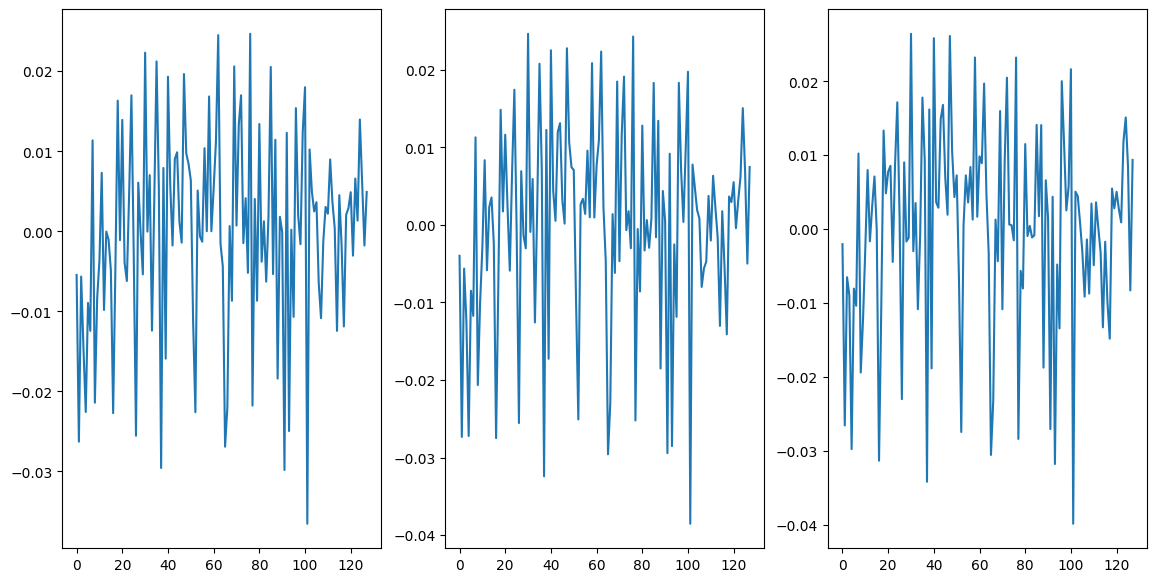

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(14,7))
ax[0].plot(modulations[0, :, 0])
ax[1].plot(modulations[0, :, 1])
ax[2].plot(modulations[0, :, 2])

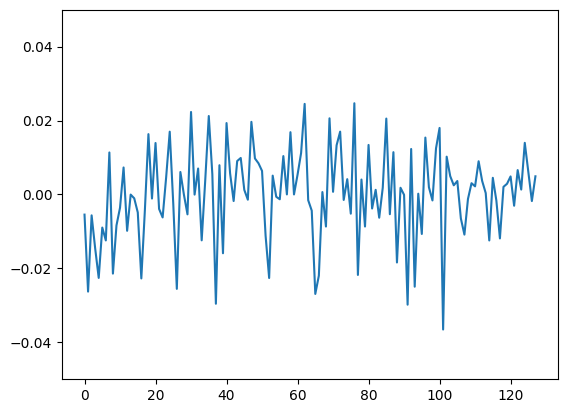

In [12]:
import matplotlib.animation as animation
import numpy as np

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

T = modulations.shape[2]

fig, ax = plt.subplots()

ax.set_ylim(-0.05, 0.05)
scat = ax.plot(modulations[0, :, 0])
x = np.linspace(0, 10)

def animate(i):
    ax.clear()
    ax.set_ylim(-0.05, 0.05)
    scat = ax.plot(modulations[0, :, i])
    return scat,

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=T, interval=50)
plot_dir = '/home/lise.leboudec/project/coral/xp/vis/'
ani.save(plot_dir + "codes.gif", dpi=300, writer=PillowWriter(fps=5))



32 : pred_test_mse
0.001599971787072718
pred_test_out_mse
0.007901197299361229
pred_train_mse
0.0001122376779676415
pred_train_out_mse
0.002573058009147644

64 : pred_test_mse
0.0017596060642972589
pred_test_out_mse
0.0032271048985421658
pred_train_mse
0.00009749349555931984
pred_train_out_mse
0.002020848449319601

128 : pred_test_mse
0.005029080901294947
pred_test_out_mse
0.005595833528786898
pred_train_mse
0.0000874398392625153
pred_train_out_mse
0.004918678198009729

256 : pred_test_mse
0.004069431684911251
pred_test_out_mse
0.004963488318026066
pred_train_mse
0.00007686253229621798
pred_train_out_mse
0.004133056849241257

512 : pred_test_mse
0.003750196425244212
pred_test_out_mse
0.011262096464633942
pred_train_mse
0.0000636339100310579
pred_train_out_mse
0.004859438166022301


In [13]:
codes = [32, 64, 128, 256, 512]
pred_train_in = [0.0001122376779676415, 0.00009749349555931984, 0.0000874398392625153, 0.00007686253229621798, 0.0000636339100310579]
pred_train_out = [0.002573058009147644, 0.002020848449319601, 0.004918678198009729, 0.004133056849241257, 0.004859438166022301]
pred_test_in = [0.001599971787072718, 0.0017596060642972589, 0.005029080901294947, 0.004069431684911251, 0.003750196425244212]
pred_test_out = [0.007901197299361229, 0.0032271048985421658, 0.005595833528786898, 0.004963488318026066, 0.011262096464633942]

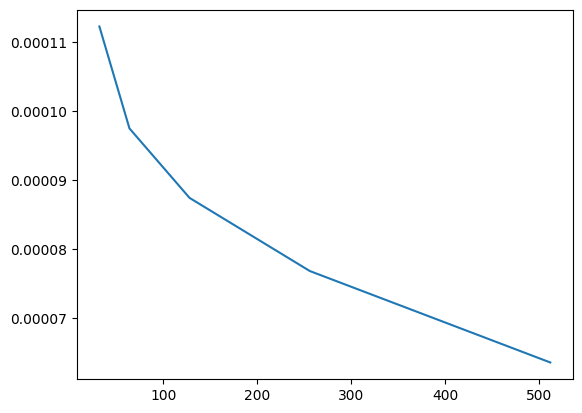

In [14]:
plt.plot(codes, pred_train_in)

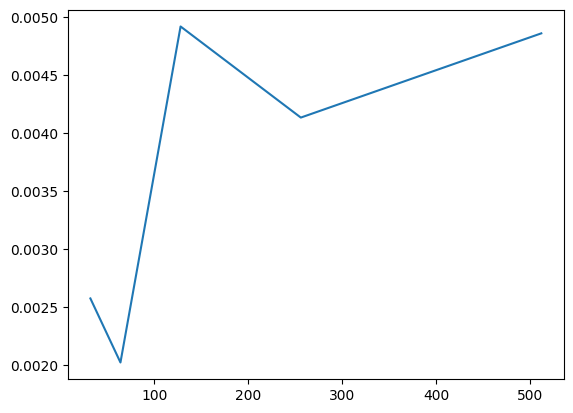

In [15]:
plt.plot(codes, pred_train_out)

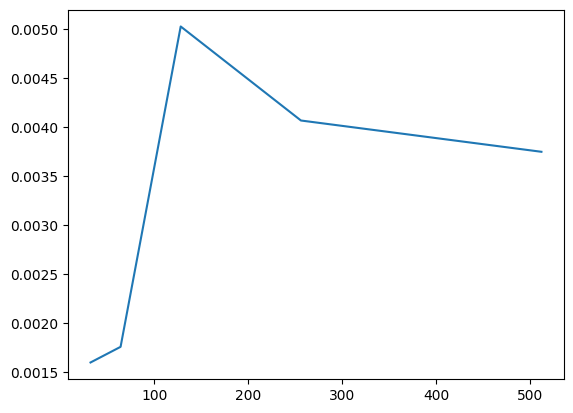

In [16]:
plt.plot(codes, pred_test_in)

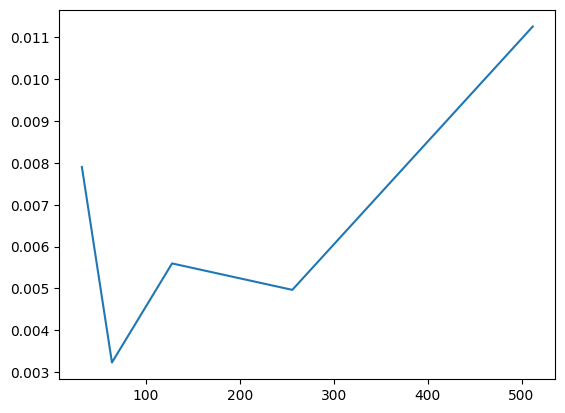

In [17]:
plt.plot(codes, pred_test_out)

grid.shape, mod.shape :  torch.Size([10, 4096, 2, 1]) torch.Size([10, 128, 1])
pred.shape :  (10, 4096, 1, 1)


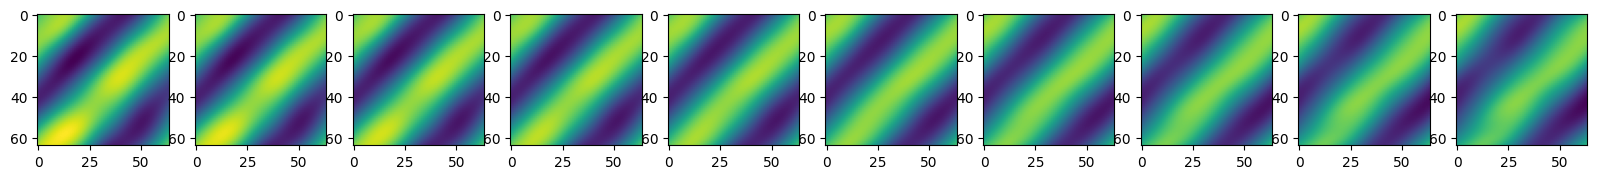

In [78]:
from coral.utils.models.get_inr_reconstructions import get_reconstructions

# modulations = torch.Size([256, 128, 20])
# grid = torch.Size([16, 819, 2, 20]) # torch.Size([16, 64, 64, 2, 20])

grid = einops.rearrange(grid_te_up1, 'B ... C T -> B (...) C T')
grid = grid[:10, :, :, 0].unsqueeze(-1).cuda() # torch.Size([10, 819, 2, 1])

base = modulations[0, :, 19] # 128
mod = base.repeat((10, 1)).unsqueeze(-1) # 10, 128, 1
mod[:, 40, :] = torch.linspace(-10, 10, 10).unsqueeze(-1)
mod = mod.cuda() 

print("grid.shape, mod.shape : ", grid.shape, mod.shape)

pred = get_reconstructions(inr, grid, mod, z_mean, z_std).cpu().detach().numpy() # torch.Size([10, 819, 1, 1])
print("pred.shape : ", pred.shape)

fig, axs = plt.subplots(1, 10, figsize=(20, 5))

for i in range(10):
    axs[i].imshow((pred[i, :, 0, 0]).reshape((64, 64)), vmin=pred.min(), vmax=pred.max())
